In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# root_dir='/content/drive/My Drive/Colab Notebooks/pyimage-covid19'
!unzip -q drive/My\ Drive/Mask.zip


In [0]:
root_dir='/content/'

In [0]:
import os
os.chdir(root_dir)

In [0]:
proj_dir = os.path.join(root_dir, 'Mask');proj_dir

'/content/Mask'

In [0]:
os.listdir(proj_dir)

['Training_mask_detector.ipynb',
 'detect_mask_video.py',
 'trained_model.h5',
 'detect_mask_image.py',
 'face_detector',
 'dataset',
 'examples']

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

In [0]:
INIT_LR = 1e-4
EPOCHS = 30
BS =12

In [0]:
dataset = os.path.join(proj_dir,'dataset')
image_paths = list(paths.list_images(dataset))
data=[]
labels=[]
print(len(image_paths))
testpath = image_paths[3]
print(testpath.split(os.path.sep))
op = testpath.split(os.path.sep)[-2];op

6791
['', 'content', 'Mask', 'dataset', 'with_mask', '283.PNG']


'with_mask'

In [0]:
for image_path in image_paths:
  label=image_path.split(os.path.sep)[-2]

  image = load_img(image_path, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

In [0]:
data = np.array(data, dtype='float32')
labels=np.array(labels)

In [0]:
test_image = image_paths[100];test_image

'/content/Mask/dataset/with_mask/PMS7BZDW0G5V4JNCOFLE.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


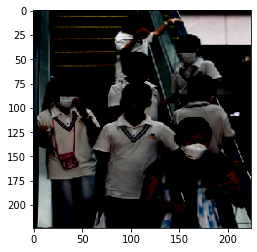

In [0]:
plt.imshow(data[92])

In [0]:
from PIL import Image
img1 = Image.open(image_paths[92])
img1.show()

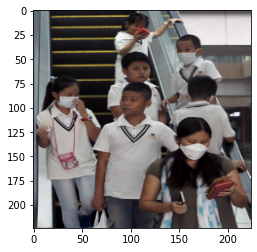

In [0]:
import cv2
im = cv2.imread(image_paths[92])
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
#one hot encoding on labels
lb = LabelBinarizer()
labels=lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
labels[100]

array([1., 0.], dtype=float32)

In [0]:
(trainX, testX, trainY, testY) =train_test_split(data,labels,
                                                 test_size=0.3,
                                                 stratify=labels,
                                                 random_state=12)

NameError: ignored

In [0]:
print(trainX.shape, trainY.shape, testX.shape,testY.shape)

NameError: ignored

## Image Data Generator for Augmentation

In [0]:
aug = ImageDataGenerator(
    rotation_range=0,
    zoom_range=0.15,
    width_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
base_model=()

In [0]:
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_tensor=Input(shape=(224,224,3)))

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name='Flatten')(head_model)
head_model = Dense(128, activation='relu')(head_model)
head_model = Dropout(0.18)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

In [0]:
model = Model(inputs=base_model.input, outputs=head_model)
for layer in base_model.layers:
  layer.trainable=False

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy'])

In [0]:
h = model.fit(
    aug.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX, testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS
    )

Epoch 1/30
169/169 [==============================] - 54s 322ms/step - loss: 0.4229 - accuracy: 0.7957 - val_loss: 0.3009 - val_accuracy: 0.8720
Epoch 2/30
169/169 [==============================] - 54s 319ms/step - loss: 0.2835 - accuracy: 0.8759 - val_loss: 0.2783 - val_accuracy: 0.8852
Epoch 3/30
169/169 [==============================] - 54s 319ms/step - loss: 0.2523 - accuracy: 0.8946 - val_loss: 0.2677 - val_accuracy: 0.8867
Epoch 4/30
169/169 [==============================] - 54s 319ms/step - loss: 0.2441 - accuracy: 0.8998 - val_loss: 0.2344 - val_accuracy: 0.8970
Epoch 5/30
169/169 [==============================] - 54s 318ms/step - loss: 0.2150 - accuracy: 0.9107 - val_loss: 0.2305 - val_accuracy: 0.9029
Epoch 6/30
169/169 [==============================] - 54s 318ms/step - loss: 0.2044 - accuracy: 0.9159 - val_loss: 0.2406 - val_accuracy: 0.8992
Epoch 7/30
169/169 [==============================] - 54s 317ms/step - loss: 0.1936 - accuracy: 0.9213 - val_loss: 0.2408 - val_ac

In [0]:
pred_idxs = model.predict(testX, batch_size=BS)

In [0]:
type(pred_idxs)
pred_idxs.shape

(1359, 2)

In [0]:
print(pred_idxs[0])

[0.06849623 0.9315038 ]


In [0]:
pred_idxs = np.argmax(pred_idxs,axis=1)

In [0]:
print(classification_report(testY.argmax(axis=1),pred_idxs,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.88      0.93       682
without_mask       0.89      0.98      0.94       677

    accuracy                           0.93      1359
   macro avg       0.94      0.93      0.93      1359
weighted avg       0.94      0.93      0.93      1359



In [0]:
#model.save(os.path.join(proj_dir, 'trained_model.h5'),save_format='h5)
model.save(os.path.join(proj_dir, 'trained_model.h5'))

In [0]:
# os.listdir(proj_dir)

In [0]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

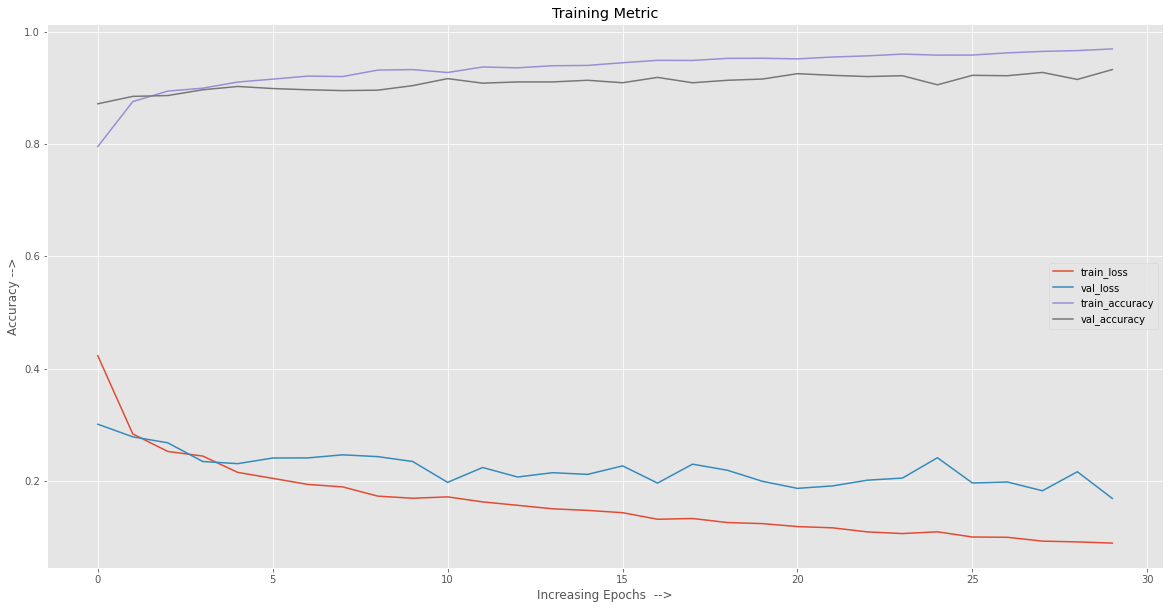

In [0]:
N=EPOCHS
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,N),h.history['loss'], label='train_loss')
plt.plot(np.arange(0,N), h.history['val_loss'], label= 'val_loss')
plt.plot(np.arange(0,N), h.history['accuracy'], label='train_accuracy')
plt.plot(np.arange(0,N), h.history['val_accuracy'], label='val_accuracy')
plt.title('Training Metric')
plt.xlabel('Increasing Epochs  -->')
plt.ylabel('Accuracy -->')
plt.legend(loc='center right')
plt.savefig(os.path.join(proj_dir,'metrics.png'))


In [0]:
%cd /content/Mask/
!python detect_mask_image.py --image examples/example_03.png

/content/face-mask-detector
2020-06-11 23:35:26.244690: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
[INFO] loading face detector model...
[INFO] loading face mask detector model...
2020-06-11 23:35:28.058747: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-11 23:35:28.093875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-11 23:35:28.094522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-06-11 23:35:28.094571: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opene